In [1]:
# 데이터 다루기
import pandas as pd
import numpy as np
from itertools import combinations

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

# 모델링
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 기타
import os
import random
from tqdm.auto import tqdm
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Optimizer, AdamW
from torch.optim.lr_scheduler import LambdaLR, CyclicLR, OneCycleLR

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip --qq '/content/drive/MyDrive/머신러닝 엔지니어링/데이콘/사기거래/data/사기거래.zip'

In [30]:
train = pd.read_csv('/content/train.csv')
val = pd.read_csv('/content/val.csv')
test = pd.read_csv('/content/test.csv')

In [31]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            x = torch.from_numpy(self.df[index]).type(torch.FloatTensor)
            y = torch.FloatTensor([self.labels[index]])
            return x, y
            #self.x = self.df[index]
            #self.y = self.labels[index]
            #return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [32]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(473,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Linear(2048,4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(4096,2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,473),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [33]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_score = 0
        avg = 1
        for epoch in range(50):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score <= score and avg > np.mean(train_loss):
                best_score = score
                avg = np.mean(train_loss)
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1, 0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [34]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [35]:
X_train = train.drop(columns=['ID']) 

X_val = val.drop(columns=['ID', 'Class']) 
y_val = val['Class']

X_test = test.drop(columns=['ID'])

In [36]:
X_train = X_train[['V3', 'V4', 'V9', 'V10', 'V11',
                   'V12', 'V14', 'V16', 'V17', 'V18']]

X_val = X_val[['V3', 'V4', 'V9', 'V10', 'V11',
               'V12', 'V14', 'V16', 'V17', 'V18']]

X_test = X_test[['V3', 'V4', 'V9', 'V10', 'V11',
                 'V12', 'V14', 'V16', 'V17', 'V18']]

In [37]:
list_drop_cols = list(X_train.columns) + ['ID']

list_etc_cols = list(train.drop(columns=list_drop_cols))

In [42]:
len(list_etc_cols)

20

In [38]:
result_val = np.zeros(val.shape[0])
result_test = np.zeros(test.shape[0])

y_val = val[['Class']]

for etc_col in list_etc_cols:

  X_train = pd.concat([X_train, train[[etc_col]]], axis=1)
  X_val = pd.concat([X_val, val[[etc_col]]], axis=1)
  X_test = pd.concat([X_test, test[[etc_col]]], axis=1)

  scaler = RobustScaler(quantile_range=(45.0, 55.0))

  scaled_train = scaler.fit_transform(X_train)

  scaled_val = scaler.transform(X_val)
  scaled_test = scaler.transform(X_test)

  scaled_train = pd.DataFrame(scaled_train)
  scaled_val = pd.DataFrame(scaled_val)
  scaled_test = pd.DataFrame(scaled_test)


  scaler = MinMaxScaler()

  scaled_train = scaler.fit_transform(scaled_train)
  scaled_val = scaler.transform(scaled_val)
  scaled_test = scaler.transform(scaled_test)

  scaled_train = pd.DataFrame(scaled_train)
  scaled_val = pd.DataFrame(scaled_val)
  scaled_test = pd.DataFrame(scaled_test)

  main_columns = list(scaled_train.columns)

  com_main = list(combinations(main_columns, 5))

  for com in com_main:

    x = com[0]
    y = com[1]
    z = com[2]
    w = com[3]
    v = com[-1]

    scaled_train[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_train[x] + scaled_train[y] + scaled_train[z] + scaled_train[w] + scaled_train[v]) / 5
    scaled_val[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_val[x] + scaled_val[y] + scaled_val[z] + scaled_val[w] + scaled_val[v]) / 5
    scaled_test[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_test[x] + scaled_test[y] + scaled_test[z] + scaled_test[w] + scaled_test[v]) / 5
  
  dimesion_reducer = SparseRandomProjection(n_components=473, eps=0.1, random_state=42)


  reduced_train = dimesion_reducer.fit_transform(scaled_train)
  reduced_val = dimesion_reducer.transform(scaled_val)
  reduced_test = dimesion_reducer.transform(scaled_test)

  reduced_train = pd.DataFrame(reduced_train)
  reduced_val = pd.DataFrame(reduced_val)
  reduced_test = pd.DataFrame(reduced_test)

  print()
  print('-'*100)
  print()
  print(f'{etc_col}')

  train_dataset = MyDataset(df=reduced_train, eval_mode=False)
  train_loader = DataLoader(train_dataset, batch_size=2**13, shuffle=True, num_workers=6)

  reduced_val=pd.concat([reduced_val, val[['Class']]], axis=1)
  val_dataset = MyDataset(df=reduced_val, eval_mode=True)
  val_loader = DataLoader(val_dataset, batch_size=2**13, shuffle=False, num_workers=6)

  model = nn.DataParallel(AutoEncoder())
  model.eval()
  optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-2)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

  trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
  trainer.fit()

  model = AutoEncoder()
  model.load_state_dict(torch.load('./best_model.pth'))
  model = nn.DataParallel(model)
  model.eval()

  reduced_val = reduced_val.drop(columns=['Class'])
  val_dataset = MyDataset(reduced_val, False)
  val_loader = DataLoader(val_dataset, batch_size=2**13, shuffle=False, num_workers=6)

  pred_val = prediction(model, 0.95, val_loader, device)
  result_val += pred_val

  val_score = f1_score(y_val, pred_val, average='macro')
  print(f'\netc col : {etc_col} / Marco F1 Score : {val_score}\n')

  test_dataset = MyDataset(reduced_test, False)
  test_loader = DataLoader(test_dataset, batch_size=2**13, shuffle=False, num_workers=6)

  pred_test = prediction(model, 0.95, test_loader, device)
  result_test += pred_test

  X_train = X_train.drop(columns=etc_col)
  X_val = X_val.drop(columns=etc_col)
  X_test = X_test.drop(columns=etc_col)


----------------------------------------------------------------------------------------------------

V1
Epoch : [0] Train loss : [0.3524628590260233] Val Score : [0.0010529271374420891])
Epoch : [1] Train loss : [0.10534716131431716] Val Score : [0.0010881344945152598])
Epoch : [2] Train loss : [0.07976299444479602] Val Score : [0.5338563455730152])
Epoch : [3] Train loss : [0.052443762842033594] Val Score : [0.8786471773914175])
Epoch : [4] Train loss : [0.038795128863837035] Val Score : [0.8674887641844412])
Epoch : [5] Train loss : [0.05193223697798593] Val Score : [0.8786471773914175])
Epoch : [6] Train loss : [0.041913182607718875] Val Score : [0.872984830495149])
Epoch : [7] Train loss : [0.048135669635874886] Val Score : [0.9165787375726882])
Epoch : [8] Train loss : [0.04364072451634066] Val Score : [0.9165787375726882])
Epoch : [9] Train loss : [0.04164548763739211] Val Score : [0.9165787375726882])
Epoch : [10] Train loss : [0.057302744793040414] Val Score : [0.916578737572

In [39]:
def check(result, ts, val):

  pred_result = []

  for i in result:

    if i >= ts:

      i = 1

    else:

      i = 0

    pred_result.append(i)

  if val == True:

    val_score = f1_score(y_val, pred_result, average='macro')
    recall = recall_score(y_val, pred_result)
    precision = precision_score(y_val, pred_result)

    print(f'Marco F1 Score : {val_score}\n')
    print(f'Recall : {recall}\n')
    print(f'Precision : {precision}\n')

    print(classification_report(y_val, pred_result))

  return pred_result

In [55]:
pred_val = check(result_val, 16, val=True)

Marco F1 Score : 0.9236496787663914

Recall : 0.8333333333333334

Precision : 0.8620689655172413

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462



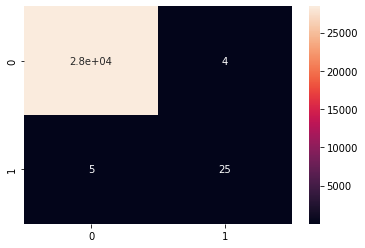

In [56]:
cf_matrix = confusion_matrix(y_val, pred_val)
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [59]:
pred_test = check(result_test, 16, val=False)

In [60]:
submit = pd.read_csv('./sample_submission.csv')

In [61]:
submit['Class'] = pred_test
submit.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [62]:
submit.to_csv('./submission_18.csv', index=False)